**任务描述**：信用评分卡模型在信用风险评估及金融风控领域得到广泛的应用，是一种以分数的形式来对用户进行评估的方法，通常评分越高代表用户的信用越好，从而风险也就越小。常见的信用评分卡有：A卡（申请评分卡）、B卡（行为评分卡）、C卡（催收评分卡）等，三者分别侧重贷前、贷中、贷后三个阶段，具体含义如引用所示。本案例选用的数据集主要涉及借款人的行为评级，因此任务是建立行为评分卡模型，该评分卡可以根据借款人在借贷之后的行为表现，预测其未来违约的概率。

> 申请评分卡：主要用于新用户的评级，预测用户开户后一定时间内违约拖欠的风险概率，可以有效排除信用不良客户和非目标客户。
> 行为评分卡： 主要用于存量用户在续存期内的管理，根据用户的历史行为数据来预测该用户未来的信贷表现，例如可能出现的逾期行为。
> 催收评分卡：主要用于存量用户是否需要催收的预测管理，预测逾期用户对催收策略反应的概率，从而采取相应催收措施。

**方法概述**：信用评分卡模型的基本原理是对进行预处理后的数据进行分箱和WOE编码转换，通过IV值进行特征选择，并采用逻辑回归算法构建模型，用ROC曲线与AUC值进行模型评估，最终根据传统方法建立起一个简单且效果不错的信用评分系统，并最终生成评分卡。主要流程为：数据获取、数据预处理、特征提取和特征选择、模型构建、模型评估和生成评分卡。

![结构图](https://s3.cn-north-1.amazonaws.com.cn/files.datafountain.cn/upload/ipynb/transform/2020-9-16-63BSpKfxPItaFCtPS2MUI.png)

## 数据介绍

首先用Python语言进行数据读取和观察：

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore') #  忽略弹出的warnings

data = pd.read_csv('../data/cs-training.csv')
data.head(10)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,7,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,8,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,9,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,10,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


12列原始属性均为数值类型。其中Unnamed: 0列类似索引的功能，每一条样本的值均不同，对模型而言没有意义，将其删除；SeriousDlqin2yrs列是该数据集的目标变量（即标签列），可以放在第一列或最后一列，方便后续模型构建时进行切分；其他10列均可作为特征进行后续处理。每一列具体代表的意义如下：

|                             $变量名$ |                                                     $描述$ |  $数据类型$ | $更改变量名为$ |
| -----------------------------------: | ---------------------------------------------------------: | ----------: | -------------: |
|                     SeriousDlqin2yrs |                               借款人是否逾期90天或更长时间 | 标签（Y/N） |          Label |
| RevolvingUtilizationOfUnsecuredLines |                                   无担保信贷额度除以总额度 |      百分比 | RevolvingRatio |
|                                  age |                                                 借款人年龄 |        整型 |            Age |
| NumberOfTime30-59DaysPastDueNotWorse |                          借款人过去两年逾期在30-59天的次数 |        整型 |         30-59D |
|                            DebtRatio |                                             每月的负债比率 |      百分比 |      DebtRatio |
|                        MonthlyIncome |                                                     月收入 |      浮点型 |  MonthlyIncome |
|      NumberOfOpenCreditLinesAndLoans | 未结贷款（如车贷或抵押贷款等）和信用额度（如信用卡）的数量 |        整型 |          OpenL |
|              NumberOfTimes90DaysLate |                                 借款人已逾期90天以上的次数 |        整型 |            90D |
|         NumberRealEstateLoansOrLines |                   抵押和房地产贷款（包括房屋净值信用额度） |        整型 |     RealEstate |
| NumberOfTime60-89DaysPastDueNotWorse |                          借款人过去两年逾期在60-89天的次数 |        整型 |         60-89D |
|                   NumberOfDependents |                       除本人以外的家属人数（配偶、子女等） |        整型 |     Dependents |

由于变量名大多过长，因此需要进行一定的简化，如上表所示。

In [2]:
### 整理数据集
data = data.iloc[:, 1:]    # 舍弃Unnamed: 0列
data.columns = ['Label', 'RevolvingRatio', 'Age', '30-59D', 'DebtRatio', 'MonthlyIncome',
                'OpenL', '90D', 'RealEstate', '60-89D', 'Dependents']    # 列重命名
data.head(10)    # 观察整理后数据集 

,Label,RevolvingRatio,Age,30-59D,DebtRatio,MonthlyIncome,OpenL,90D,RealEstate,60-89D,Dependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


## 数据预处理

### 缺失值处理

统计数据集的缺失情况，可以发现所有特征中仅有两列含缺失值，即MonthlyIncome（月收入）和Dependents（家属人数）。其中月收入特征缺失比例为19.8%，缺失较多，不能直接删除对应样本，本案例中选用随机森林进行建模填充；家属人数特征缺失比例为2.6%，占比较小，可以考虑删除对应样本行，也可以进行填充，为了尽可能多地利用数据，本案例选用众数进行填充。

In [3]:
### 统计数据集缺失情况
missingDf = data.isnull().sum().sort_values(ascending=False).reset_index()
missingDf.columns = ['feature', 'miss_num']    
missingDf['miss_percentage'] = missingDf['miss_num'] / data.shape[0]    # 缺失值比例

In [4]:
missingDf    # 查看缺失情况

,feature,miss_num,miss_percentage
0,MonthlyIncome,29731,0.198207
1,Dependents,3924,0.026160
2,60-89D,0,0.000000
3,RealEstate,0,0.000000
4,90D,0,0.000000
5,OpenL,0,0.000000
6,DebtRatio,0,0.000000
7,30-59D,0,0.000000
8,Age,0,0.000000
9,RevolvingRatio,0,0.000000


In [5]:
### MonthlyIncome特征处理
from sklearn.ensemble import RandomForestRegressor    

# 用MonthlyIncome特征值非空的样本构建训练集，MonthlyIncome特征值缺失的样本构建测试集
rfDf = data.iloc[:, [5,1,2,3,4,6,7,8,9]]    # 原始数据集中的无缺失数值特征
rfDf_train = rfDf.loc[rfDf['MonthlyIncome'].notnull()]
rfDf_test = rfDf.loc[rfDf['MonthlyIncome'].isnull()]
   
# 划分训练数据和标签（label）
X = rfDf_train.iloc[:, 1:]
y = rfDf_train.iloc[:, 0]
# 训练过程
rf = RandomForestRegressor(random_state=0,n_estimators=200,max_depth=3,n_jobs=-1)    # 这里重在理解过程，因此仅简单选取部分参数
rf.fit(X, y)
# 预测过程
pred = rf.predict(rfDf_test.iloc[:, 1:]).round(0)    # 预测值四舍五入并保留一位小数点
data.loc[(data['MonthlyIncome'].isnull()), 'MonthlyIncome'] = pred    # 填补缺失值

print("此时的MonthlyIncome特征统计指标:\n")
print(rfDf['MonthlyIncome'].describe())

此时的MonthlyIncome特征统计指标:

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64


In [6]:
### Dependents特征处理
data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)    # 这里采用众数填充
print("此时Dependents特征统计指标:\n")
print(data['Dependents'].describe())

此时Dependents特征统计指标:

count    150000.000000
mean          0.737413
std           1.107021
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: Dependents, dtype: float64


### 异常值处理

用箱型图可以直观地对每一列特征进行观察，找到偏离正常范围较大的异常值。

#### 百分比类特征

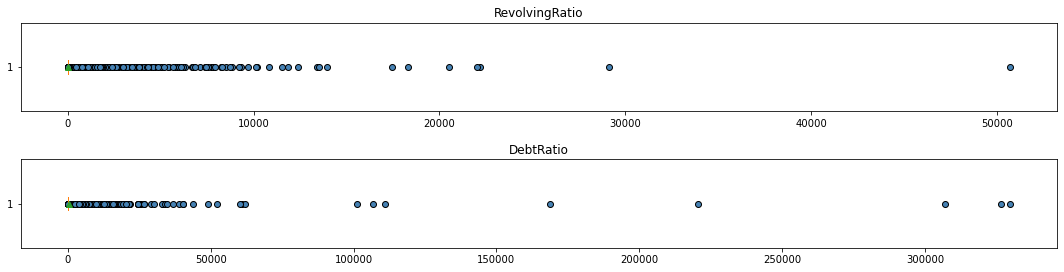

In [8]:
### 观察异常值情况
import seaborn as sns
import matplotlib.pyplot as plt    # 可视化
# 在Jupyter notebook里嵌入图片
%matplotlib inline

# 分析百分比特征
fig = plt.figure(figsize=(15,4)) # 建立图像

# RevolvingRatio特征
ax1 = fig.add_subplot(211)    # 子图1
list1 = list(data['RevolvingRatio'])
ax1.boxplot(list1, vert=False, showmeans=True, flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax1.set_title('RevolvingRatio')

# DebtRatio特征
ax2 = fig.add_subplot(212)    # 子图2
list2 = list(data['DebtRatio'])
ax2.boxplot(list2, vert=False, showmeans=True, flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax2.set_title('DebtRatio')

plt.tight_layout(pad=1.5)    # 设置子图之间的间距
plt.show() # 展示箱型图

RevolvingRatio代表信贷额度除以总额度的百分比，DebtRatio代表每月的负债比率，从实际意义出发进行理解这两者的取值范围都应该在[0,1]之间。因此选择的处理方法是将大于1的特征值视为异常值，用[0,1]之间特征值的均值进行填充。

In [9]:
### 处理百分比类异常值
# RevolvingRatio特征
ruulDf = data[data['RevolvingRatio'] <= 1]    # 去掉高于1的部分
ruul_mean = ruulDf['RevolvingRatio'].mean()    # 计算均值
data.loc[data['RevolvingRatio'] > 1, 'RevolvingRatio'] = ruul_mean    # 均值替代

# DebtRatio特征
ruulDf = data[data['DebtRatio'] <= 1]    # 去掉高于1的部分
ruul_mean = ruulDf['DebtRatio'].mean()    # 计算均值
data.loc[data['DebtRatio'] > 1, 'DebtRatio'] = ruul_mean    # 均值替代

#### 逾期特征

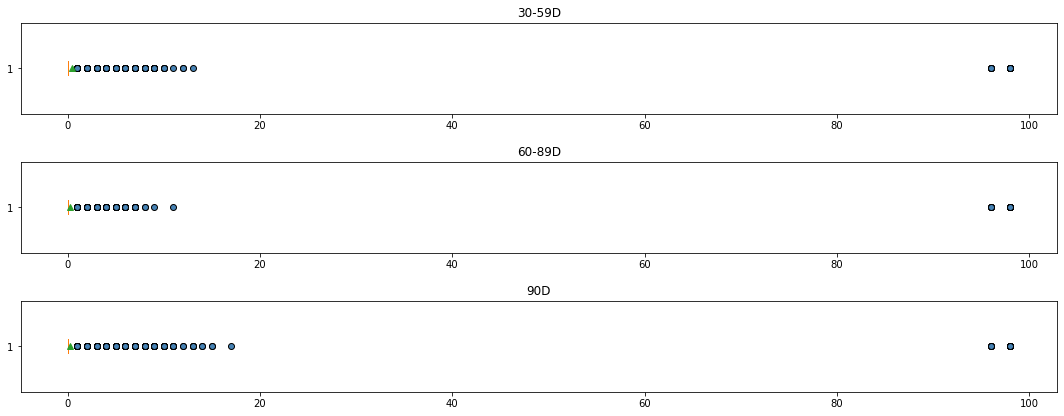

In [10]:
### 分析逾期特征
fig = plt.figure(figsize=(15,6)) # 建立图像

# 30-59D特征
ax1 = fig.add_subplot(311)    # 子图1
list1 = list(data['30-59D'])
ax1.boxplot(list1, vert=False, showmeans=True, flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax1.set_title('30-59D')

# 60-89D特征
ax2 = fig.add_subplot(312)    # 子图2
list2 = list(data['60-89D'])
ax2.boxplot(list2, vert=False, showmeans=True, flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax2.set_title('60-89D')

# 90D特征
ax3 = fig.add_subplot(313)    # 子图3
list3 = list(data['90D'])
ax3.boxplot(list3, vert=False, showmeans=True, flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax3.set_title('90D')

plt.tight_layout(pad=1.5)    # 设置子图之间的间距
plt.show() # 展示箱型图

图中三列特征分别表示用户逾期次数在三个不同时间范围内的次数，从箱型图中可以看出，逾期接近100次左右的特征值原理箱型图的正常范围，可以视为异常值。分析发现这三列特征异常样本数均相同，猜想是否有269条样本同时在三列特征的取值中出现异常。

In [11]:
### 分析异常样本
# 异常样本数
row1 = data[data['30-59D'] > 80]
print("30-59D特征的异常样本数：", row1.shape[0])
row2 = data[data['60-89D'] > 80]
print("60-89D特征的异常样本数：", row2.shape[0])
row3 = data[data['90D'] > 80]
print("90D特征的异常样本数：", row3.shape[0])

30-59D特征的异常样本数： 269
60-89D特征的异常样本数： 269
90D特征的异常样本数： 269


In [12]:
# 是否属于同样的269条样本？
sameDf = data[data['30-59D'] > 80]
sameDf = sameDf[sameDf['60-89D'] > 80]
sameDf = sameDf[sameDf['90D'] > 80]
print("三列特征同时出现异常的样本数为：", sameDf.shape[0])

三列特征同时出现异常的样本数为： 269


因此我们的猜想是正确的，由于这些样本出现多列异常值，且样本数在数据集中仅占很小的一部分，因此考虑将其直接删除。

In [13]:
### 处理逾期特征异常值
data.drop(data[data['30-59D']  > 80].index, inplace = True)    # 根据索引删除样本
print("剩下的样本数为：", data.shape[0])

剩下的样本数为： 149731


#### 年龄特征

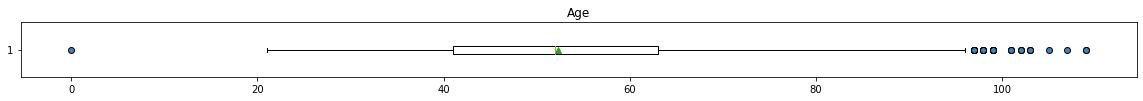

In [14]:
### 分析年龄特征
plt.figure(figsize=(20,1)) # 建立图像

bp_list = list(data['Age'])
plt.boxplot(bp_list, vert=False, showmeans=True, flierprops = {"marker":"o","markerfacecolor":"steelblue"})
plt.title('Age')

plt.show() # 展示箱型图

Age代表借款人的年龄，从箱型图中很明显可以看出，年龄取值为0是异常值，由于只有一条样本，因此可以直接删除；而从实际情况出发，我们认为年龄在100左右的人应当不在借贷用户的年龄范围内，因此同样将超过箱型图上须的样本删除。

In [15]:
# 箱型图的边界
q1 = data['Age'].describe()['25%']
q3 = data['Age'].describe()['75%']
iqr = q3 - q1
print("箱型图上须：", q3 + 1.5*iqr)
print("箱型图下须：", q1 - 1.5*iqr)

箱型图上须： 96.0
箱型图下须： 8.0


In [16]:
print("低于箱型图下须的样本条数：", data[data['Age'] < 8].shape[0])
print("超过箱型图上须的样本条数：", data[data['Age'] > 96].shape[0])

低于箱型图下须的样本条数： 1
超过箱型图上须的样本条数： 45


In [17]:
### 处理年龄特征异常值
data.drop(data[data['Age'] == 0].index, inplace = True)    # 根据索引删除样本
data.drop(data[data['Age'] > 96].index, inplace = True)
print("剩下的样本数为：", data.shape[0])

剩下的样本数为： 149685


#### 其余特征

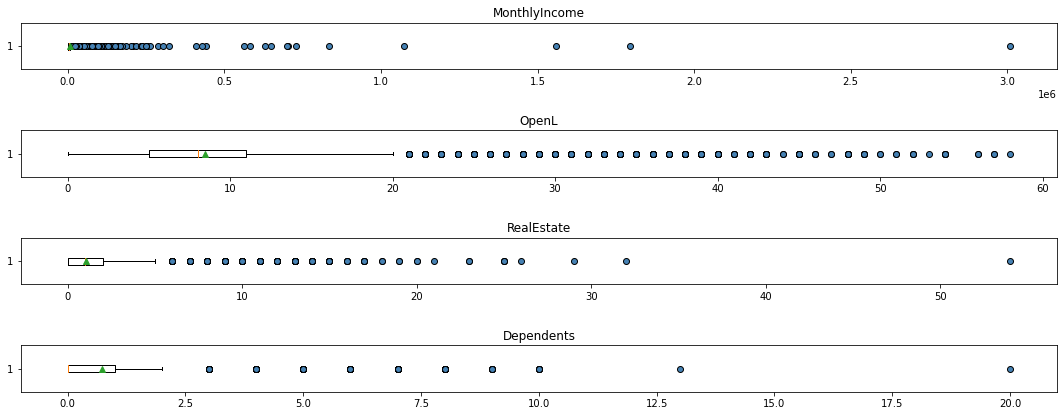

In [18]:
### 分析其余特征
fig = plt.figure(figsize=(15,6)) # 建立图像

# MonthlyIncome特征：月收入
ax1 = fig.add_subplot(411)    # 子图1
list1 = list(data['MonthlyIncome'])
ax1.boxplot(list1, vert=False, showmeans=True, flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax1.set_title('MonthlyIncome')

# OpenL特征：未结贷款和信用额度的数量
ax2 = fig.add_subplot(412)    # 子图2
list2 = list(data['OpenL'])
ax2.boxplot(list2, vert=False, showmeans=True, flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax2.set_title('OpenL')

# RealEstate特征：抵押和房地产贷款数量
ax3 = fig.add_subplot(413)    # 子图3
list3 = list(data['RealEstate'])
ax3.boxplot(list3, vert=False, showmeans=True, flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax3.set_title('RealEstate')

# Dependents特征：除本人以外的家属人数
ax4 = fig.add_subplot(414)    # 子图4
list4 = list(data['Dependents'])
ax4.boxplot(list4, vert=False, showmeans=True, flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax4.set_title('Dependents')

plt.tight_layout(pad=1.5)    # 设置子图之间的间距
plt.show() # 展示箱型图

从上图中，可看到上述4列特征均存在一定量的异常值，且异常值均分布在箱型图的其中一侧。我们在此暂时不进行处理，因为后续还有特征分箱环节。分箱可以直接将这些异常值限制在最右侧箱体中并进行重新编码，而不会用到原始特征值，这样也可以起到处理异常值的作用。

## 特征工程
在传统的信用卡评分方法中，在特征工程环节，对特征往往采用“分箱-WOE编码-通过IV值选择”的流程进行处理，下面将主要对这三个环节进行原理介绍和代码讲解，其中代码方面将woe和iv的计算也统一到分箱函数中进行计算。

### 特征相关性分析
使用相关系数热度图对特征之间的相关性进行分析：

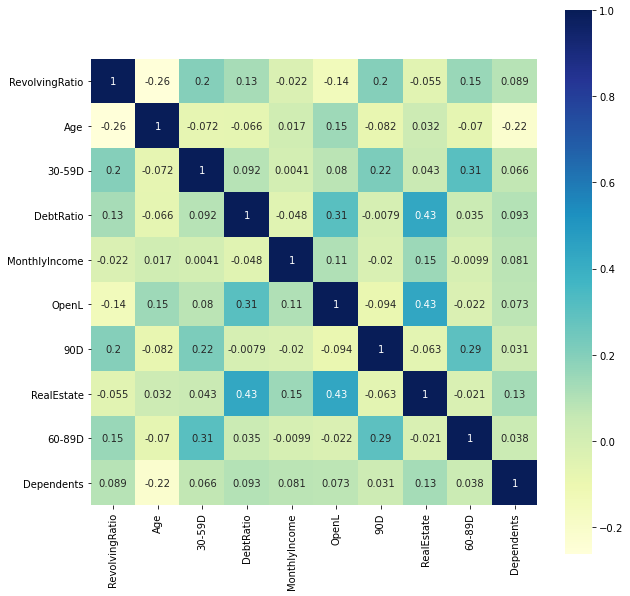

In [19]:
### 皮尔逊相关系数
nu_fea = data.columns[1:]    # 选择数值类特征计算相关系数
nu_fea = list(nu_fea)    # 特征名列表
pearson_mat = data[nu_fea].corr(method='pearson')    # 计算皮尔逊相关系数矩阵

plt.figure(figsize=(10,10)) # 建立图像
sns.heatmap(pearson_mat, square=True, annot=True, cmap="YlGnBu")    # 用热度图表示相关系数矩阵
plt.show() # 展示热度图

由图可观察到各个特征之间的相关性较小，可以初步判定特征之间不存在明显的多重共线性问题（相关系数绝对值小于0.6），暂时不需要删除冗余特征。

### 新特征构建
原始数据集中有10列特征，我们可以再构建一些新的连续值特征作为备选，同时也可对比原特征与新特征的预测能力。下面简单举例：

In [20]:
### 构建新特征
# IncAvg:家庭中每个人分摊的平均月收入
data['IncAvg'] = data['MonthlyIncome'] / (data['Dependents'] + 1)    
# MonthlyDept:每月的债务
data['MonthlyDept'] = data['MonthlyIncome'] * data['DebtRatio']
# DeptAvg:家庭中平均每个人分摊每月应还债务
data['DeptAvg'] = data['MonthlyDept'] / (data['Dependents'] + 1)

data[['IncAvg', 'MonthlyDept', 'DeptAvg']].head(10)    # 查看新特征

,IncAvg,MonthlyDept,DeptAvg
0,3040.000000,7323.197016,2441.065672
1,1300.000000,316.878123,158.439061
2,3042.000000,258.914887,258.914887
3,3300.000000,118.963951,118.963951
4,63588.000000,1584.975094,1584.975094
5,1750.000000,1314.624392,657.312196
6,8311.000000,2518.413491,2518.413491
7,3500.000000,734.790059,734.790059
8,1159.000000,351.202170,351.202170
9,7894.666667,14359.393699,4786.464566


### 分箱

由于10列特征均为数值类特征，因此采用数值特征的特征提取方法，这里采用特征分箱进行处理。连续性特征常用的分箱方法有如下几种：

- 等距分箱：每个分箱的间距相等。
- 等频分箱：每个分箱的频率相等。
- 最优分箱：也称自动化分箱，通常采用一个评价指标来判断分箱合适的宽度和频率，评判标准可以是卡方值（卡方分箱）、熵值（单变量决策树算法）、相关系数、IV值等等。
- 自定义分箱：如果常用的分箱方法不能满足要求的话，还可以从业务解释或者数据分布出发，自行划分箱体区间，做自定义分箱。

本案例中采用最优分箱结合自定义分箱的方法进行处理。

### WOE

WOE即证据权重（Weight of Evidence），是对原始特征的一种有监督的编码方式。在对特征进行分箱之后，分箱后的值不能直接输入模型，需要用WOE进行分箱后的编码。分箱后，对于第i组，计算WOE如下： $$ WOE_i = \ln \frac{p(bad)}{p(good)} = \ln \frac{\frac{B_i}{B_T}}{\frac{G_i}{G_T}}$$ $p(bad)$代表该组中坏样本占所有坏样本的比例，$p(good)$代表该组中好样本占所有好样本的比例。
本例中坏样本即‘SeriousDlqin2yrs’列对应特征值为1的样本，好样本即‘SeriousDlqin2yrs’列对应特征值为0的样本。

### IV值

IV值即特征信息值（Information Value），用来衡量特征的预测能力。 $$ IV = \sum_{i}^n IV_i = \sum_{i}^n (p(bad) - p(good)) * WOE_i $$

IV的取值范围和预测能力对应如下表：

|         IV | 预测能力 |
| ---------: | -------: |
|      <0.03 |       无 |
| 0.03～0.09 |       低 |
|  0.1～0.29 |       中 |
|  0.3～0.49 |       高 |
|      >=0.5 |     极高 |

### 代码

------

#### 最优分箱代码

In [21]:
### 定义分箱函数
from scipy.stats import stats    # scipy.stats是一个很好的统计推断包

def optimal_bins(Y, X, n):
    """
    :param Y: 目标变量
    :param X: 待分箱特征
    :param n: 分箱数初始值
    :return: 统计值、分箱边界值列表、woe值、iv值
    """
    r = 0    # 初始值
    total_bad = Y.sum()    # 总的坏样本数
    total_good = Y.count() - total_bad    # 总的好样本数
    # 分箱过程
    while np.abs(r) < 1:    
        df1 = pd.DataFrame({'X':X, 'Y':Y, 'bin':pd.qcut(X, n, duplicates='drop')})    # qcut():基于量化的离散化函数
        df2 = df1.groupby('bin')
        r, p = stats.spearmanr(df2.mean().X, df2.mean().Y)
        n = n - 1
    # 计算woe值和iv值
    df3 = pd.DataFrame()
    df3['min_'+X.name] = df2.min().X 
    df3['max_'+X.name] = df2.max().X 
    df3['sum'] = df2.sum().Y
    df3['total'] = df2.count().Y
    df3['rate'] = df2.mean().Y
    df3['badattr'] = df3['sum'] / total_bad
    df3['goodattr'] = (df3['total'] - df3['sum']) / total_good
    df3['woe'] = np.log(df3['badattr'] / df3['goodattr'])
    iv = ((df3['badattr'] - df3['goodattr']) * df3['woe']).sum()
    df3 = df3.sort_values(by='min_'+X.name).reset_index(drop=True)
    # 分箱边界值列表
    cut = []
    cut.append(float('-inf'))
    for i in range(1, n+1):
        qua = X.quantile(i / (n+1))
        cut.append(round(qua, 6))
    cut.append(float('inf'))
    # woe值列表
    woe = list(df3['woe'])
    
    return df3, cut, woe, iv

In [22]:
# 观察RevolvingRatio特征各分箱情况
rrDf, cut_rr, woe_rr, iv_rr = optimal_bins(data.Label,data.RevolvingRatio,n=10)
rrDf

,min_RevolvingRatio,max_RevolvingRatio,sum,total,rate,badattr,goodattr,woe
0,0.000000,0.029805,687,37422,0.018358,0.069563,0.262751,-1.328981
1,0.029808,0.153559,744,37421,0.019882,0.075334,0.262336,-1.247694
2,0.153560,0.504270,2818,37421,0.075305,0.285338,0.247502,0.142257
3,0.504272,1.000000,5627,37421,0.150370,0.569765,0.227410,0.918468


In [23]:
cut_rr

[-inf, 0.029805, 0.153559, 0.50427, inf]

如上，RevolvingRatio最终被分箱成四个区间。同理对MonthlyIncome、Age、DebtRatio特征进行处理：

In [24]:
# MonthlyIncome特征
miDf,cut_mi,woe_mi,iv_mi = optimal_bins(data.Label,data.MonthlyIncome,n=10)
print("MonthlyIncome特征分箱情况：", cut_mi)
# Age特征
ageDf,cut_age,woe_age,iv_age = optimal_bins(data.Label,data.Age,n=10)
print("Age特征分箱情况：", cut_age)
# DebtRatio特征
drDf,cut_dr,woe_dr,iv_dr = optimal_bins(data.Label,data.DebtRatio,10)
print("DebtRatio特征分箱情况：", cut_dr)

MonthlyIncome特征分箱情况： [-inf, 3300.0, 6750.0, inf]
Age特征分箱情况： [-inf, 33.0, 40.0, 45.0, 50.0, 54.0, 59.0, 64.0, 71.0, inf]
DebtRatio特征分箱情况： [-inf, 0.238944, 0.312212, inf]


对新特征进行处理：

In [26]:
### 新特征
# IncAvg特征
newDf1,cut_new1,woe_new1,iv_new1 = optimal_bins(data.Label, data.IncAvg, 10)
# MonthlyDept特征
newDf2,cut_new2,woe_new2,iv_new2 = optimal_bins(data.Label, data.MonthlyDept, 10)
# DeptAvg特征
newDf3,cut_new3,woe_new3,iv_new3 = optimal_bins(data.Label, data.DeptAvg, 10)

print("IncAvg特征特征分箱情况：", cut_new1)
print("MonthlyDept特征分箱情况：", cut_new2)
print("DeptAvg特征分箱情况：", cut_new3)

IncAvg特征特征分箱情况： [-inf, 1700.0, 2959.0, 5400.0, inf]
MonthlyDept特征分箱情况： [-inf, inf]
DeptAvg特征分箱情况： [-inf, 351.20217, 773.917466, 1591.840815, inf]


可见三列新特征中MonthlyDept不适合使用最优分箱方法，需要寻找新的分箱方法进行处理。

####  自定义分箱代码
对其他6列原始特征，用最优分箱计算效果同样较差。

In [27]:
### 最优分箱结果
df1,cut1,woe1,iv1 = optimal_bins(data.Label,data['30-59D'],n=10)
print(cut1)
df2,cut2,woe2,iv2 = optimal_bins(data.Label,data.OpenL,n=10)
print(cut2)
df3,cut3,woe3,iv3 = optimal_bins(data.Label,data['90D'],n=10)
print(cut3)
df4,cut4,woe4,iv4 = optimal_bins(data.Label,data['60-89D'],n=10)
print(cut4)
df5,cut5,woe5,iv5 = optimal_bins(data.Label,data.RealEstate,n=10)
print(cut5)
df6,cut6,woe6,iv6 = optimal_bins(data.Label,data.Dependents,n=10)
print(cut6)

[-inf, 0.0, 0.0, 0.0, 0.0, 0.0, inf]
[-inf, inf]
[-inf, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, inf]
[-inf, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, inf]
[-inf, inf]
[-inf, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, inf]


原因可能是某些特征值占比过高、阈值设置不合适等等，因此不能满足最优分段的要求。又由于特征不多且容易观察，因此本案例采取自定义分箱的方式进行处理。

In [29]:
### 定义分箱函数
def custom_bins(Y, X, binList):
    """
    :param Y: 目标变量
    :param X: 待分箱特征
    :param binList: 分箱边界值列表
    :return: 统计值、woe值、iv值
    """
    r = 0
    total_bad = Y.sum()     
    total_good = Y.count() - total_bad
    # 等距分箱
    df1 = pd.DataFrame({'X':X, 'Y':Y, 'bin':pd.cut(X, binList)})
    df2 = df1.groupby('bin', as_index = True)
    r, p = stats.spearmanr(df2.mean().X, df2.mean().Y)
    # 计算woe值和iv值 
    df3 = pd.DataFrame()
    df3['min_'+X.name] = df2.min().X 
    df3['max_'+X.name] = df2.max().X 
    df3['sum'] = df2.sum().Y
    df3['total'] = df2.count().Y
    df3['rate'] = df2.mean().Y
    df3['badattr'] = df3['sum'] / total_bad
    df3['goodattr'] = (df3['total'] - df3['sum']) / total_good
    df3['woe'] = np.log(df3['badattr'] / df3['goodattr'])
    iv = ((df3['badattr'] - df3['goodattr']) * df3['woe']).sum()
    df3 = df3.sort_values(by='min_'+X.name).reset_index(drop=True)
    woe = list(df3['woe'])
    
    return df3, woe, iv

In [30]:
### 自定义分箱区间如下
# 原始特征
ninf = float('-inf')
pinf = float('inf')
cut_thirty = [ninf, 0, 1, 3, 5, pinf]    # 30-59D特征
cut_open = [ninf,1, 2, 3, 5, pinf]    # OpenL特征
cut_ninety = [ninf, 0, 1, 3, 5, pinf]    # 90D特征
cut_re = [ninf, 0, 1, 2, 3, pinf]    # RealEstate特征
cut_sixty = [ninf, 0, 1, 3, pinf]    # 60-89D特征
cut_dpt = [ninf, 0, 1, 2, 3, 5, pinf]    # Dependents特征

In [31]:
# 新特征 
data['MonthlyDept'].describe()    # 观察新特征MonthlyDept统计属性

count    149685.000000
mean       1706.803818
std        1739.175493
min           0.000000
25%         413.852301
50%        1208.640180
75%        2518.413491
max       57086.823924
Name: MonthlyDept, dtype: float64

In [32]:
cut_new2 = [ninf, 414, 1209, 2518, pinf]    # 新特征MonthlyDept自定义分箱

In [33]:
### 计算统计值、woe和iv
thirtyDf, woe_thirty, iv_thirty = custom_bins(data.Label, data['30-59D'], cut_thirty)    # 30-59D特征
openDf, woe_open, iv_open = custom_bins(data.Label, data.OpenL, cut_open)    # OpenL特征
ninetyDf, woe_ninety, iv_ninety = custom_bins(data.Label, data['90D'], cut_ninety)    # 90D特征
reDf, woe_re, iv_re = custom_bins(data.Label, data.RealEstate, cut_re)    # RealEstate特征
sixtyDf, woe_sixty, iv_sixty = custom_bins(data.Label, data['60-89D'], cut_sixty)    # 60-89D特征
dptDf, woe_dpt, iv_dpt = custom_bins(data.Label, data.Dependents, cut_dpt)    # Dependents特征
newDf2, woe_new2, iv_new2 = custom_bins(data.Label, data.MonthlyDept, cut_new2)    # 新特征MonthlyDept

#### IV值筛选特征

In [34]:
### 列表查看iv值
ivDf = pd.DataFrame(columns=['feature', 'iv'])
feaList = list(data.columns[1:])
ivList = [iv_rr, iv_age, iv_thirty, iv_dr, iv_mi, iv_open, iv_ninety, iv_re, iv_sixty, iv_dpt, iv_new1, iv_new2, iv_new3]
for i, x in enumerate(feaList):
    ivDf.loc[i, 'feature'] = x
    ivDf.loc[i, 'iv'] = ivList[i]
ivDf = ivDf.sort_values(by='iv', ascending=False).reset_index(drop=True)    # 降序排列
ivDf    # 查看表格

,feature,iv
0,90D,0.847691
1,RevolvingRatio,0.809891
2,30-59D,0.723697
3,60-89D,0.566693
4,Age,0.251094
5,IncAvg,0.0753287
6,OpenL,0.0701187
7,RealEstate,0.0561698
8,MonthlyIncome,0.0423459
9,Dependents,0.0372899


根据iv值表格，小于0.1的特征可视为弱特征。由于评分卡需要的特征可以较少（一个评分卡中特征一般不超过15维），且本案例仅做演示，因此将iv值小于0.1的特征弃之不用。即删除OpenL、RealEstate、MonthlyIncome、Dependents、DebtRatio 5列原始特征及三列新特征，剩余5列特征进行WOE编码。

In [35]:
### WOE编码
data['90D'] = pd.cut(data['90D'], bins=cut_ninety, labels=woe_ninety)    # 90D特征
data['RevolvingRatio'] = pd.cut(data['RevolvingRatio'], bins=cut_rr, labels=woe_rr)    # RevolvingRatio特征
data['30-59D'] = pd.cut(data['30-59D'], bins=cut_thirty, labels=woe_thirty)    # 30-59D特征
data['60-89D'] = pd.cut(data['60-89D'], bins=cut_sixty, labels=woe_sixty)    # 60-89D特征
data['Age'] = pd.cut(data['Age'], bins=cut_age, labels=woe_age)    # Age特征

# 特征选择
data = data[['Label', '90D', 'RevolvingRatio', '30-59D', '60-89D', 'Age']]    
data.head(10)    # 此时的数据集

,Label,90D,RevolvingRatio,30-59D,60-89D,Age
0,1,-0.375976,0.918468,1.750354,-0.274423,0.268340
1,0,-0.375976,0.918468,-0.527686,-0.274423,0.378025
2,0,1.972150,0.918468,0.917280,-0.274423,0.378025
3,0,-0.375976,0.142257,-0.527686,-0.274423,0.559978
4,0,-0.375976,0.918468,0.917280,-0.274423,0.204901
5,0,-0.375976,0.142257,-0.527686,-0.274423,-1.140648
6,0,-0.375976,0.142257,-0.527686,-0.274423,-0.204940
7,0,-0.375976,0.918468,-0.527686,-0.274423,0.378025
8,0,-0.375976,-1.247694,-0.527686,-0.274423,0.559978
9,0,-0.375976,0.142257,-0.527686,-0.274423,-0.204940


## 算法模型构建

### 划分数据集

In [36]:
from sklearn.model_selection import train_test_split    # 数据集划分模块

X = data.iloc[:, 1:]    # 特征
y = data.iloc[:, 0]    # 目标变量

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)    # 训练集：测试集 = 7:3

### 逻辑回归

In [37]:
from sklearn.linear_model import LogisticRegression
'''
LogisticRegression一些重要参数的默认值：

penalty：正则化类型，默认值'l2'，当solver='liblinear'时还可以选择'l1'
solver：最优化方法，默认值'liblinear'，还可以选择'newton-cg', 'lbfgs', 'sag', 'saga'
tol：迭代终止的阈值，默认值为1e-4
max_iter：最大迭代次数，默认值100    
（...等其他参数）
'''
model1 = LogisticRegression()    # 首先全部采用默认值进行训练
clf1 = model1.fit(X_train, y_train)    # 模型训练
y_pred1 = clf1.predict(X_test)    # 模型预测
y_score1 = model1.decision_function(X_test)

## 模型评估
二分类问题可以使用ROC曲线和AUC值进行评估，由于二元分类器通常得到的结果是一个概率值而非0、1类别，因此需要使用阈值进行样本类别的划分。由此得到二元预测值之后，可以构建起一个混淆矩阵：

![混淆矩阵](https://s3.cn-north-1.amazonaws.com.cn/files.datafountain.cn/upload/ipynb/transform/2020-9-16-ckZrgx5uaQAGXFRpL-zJp.png)

从混淆矩阵中，可以计算出ROC曲线上点的坐标值：

- 横坐标FPR：假阳率，计算的是分类器错认为正类的负实例占所有负实例的比例。 $$FPR = \frac{FP}{TN+FP}$$
- 纵坐标TPR：真阳率，计算的是分类器所识别出的正实例占所有正实例的比例。 $$TPR = \frac{TP}{TP+FN}$$

选取的阈值不同，得到的TPR和FPR值就不同，将这些值对应的点连起来就构成了ROC曲线，它能帮助我们了解分类器的性能，ROC曲线越靠拢(0,1)点，越偏离45度对角线，就代表预测效果越好。

AUC则定义为ROC曲线下的面积，其取值一般应当在0.5到1之间，如果AUC值小于0.5，说明预测效果较差。从另一个角度看，AUC值还是一个概率值，假设随机挑选一个正样本及负样本，模型将正样本排在负样本前面的概率就是AUC值。AUC值越大，模型越有可能将正样本排在负样本前面，从而能够更好地分类。

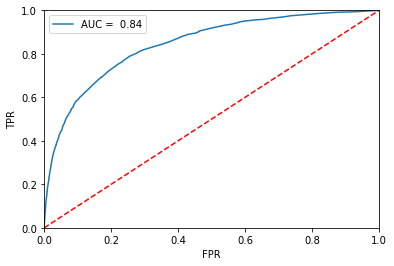

In [38]:
from sklearn.metrics import roc_curve, auc

# 计算ROC-AUC相关数值
fpr1, tpr1, threshold1 = roc_curve(y_test, y_score1)
auc_value1 = auc(fpr1, tpr1)

# 画图
plt.figure()    # 建立图像

plt.plot(fpr1,tpr1, label="AUC = % 0.2f" % auc_value1)
plt.legend()    # 加入图例
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')

plt.show()    # 展示图像

由图可见，模型的预测效果相对较好。接下来调整模型的参数进行预测效果的对比：

In [39]:
print("默认参数对应的AUC值为：", auc_value1)

# 修改最优化方式
model2 = LogisticRegression(solver='sag')    
clf2 = model2.fit(X_train, y_train)    
y_score2 = model2.decision_function(X_test)
fpr2, tpr2, threshold2 = roc_curve(y_test, y_score2)
auc_value2 = auc(fpr2, tpr2)
print("修改最优化方式后AUC值为：", auc_value2)

# 修改最大迭代次数
model3 = LogisticRegression(max_iter=300)    
clf3 = model3.fit(X_train, y_train)    
y_score3 = model3.decision_function(X_test)
fpr3, tpr3, threshold3 = roc_curve(y_test, y_score3)
auc_value3 = auc(fpr3, tpr3)
print("修改最大迭代次数后AUC值为：", auc_value3)

# 修改迭代终止阈值
model4 = LogisticRegression(tol=1e-6)    
clf4 = model4.fit(X_train, y_train)    
y_score4 = model4.decision_function(X_test)
fpr4, tpr4, threshold4 = roc_curve(y_test, y_score4)
auc_value4 = auc(fpr4, tpr4)
print("修改迭代终止阈值后AUC值为：", auc_value4)

默认参数对应的AUC值为： 0.844755822319142
修改最优化方式后AUC值为： 0.8447548752041563
修改最大迭代次数后AUC值为： 0.844755822319142
修改迭代终止阈值后AUC值为： 0.844755822319142


本案例中，作为举例，且由于逻辑回归模型可调节的参数较少，因此仅简单地修改单个参数进行对比，从上述结果可见，其对预测结果的影响并不明显。而在往后处理其他更复杂的数据集和任务、使用更复杂的算法模型时，可以更多地尝试不同的参数组合，并从中选取能够使得预测效果最优的一组参数。

## 生成评分卡

### 原理介绍

前述工作完成了模型构建和评估，以下是将逻辑回归模型转换成标准的信用评分卡的过程。

传统的信用卡评分系统构建步骤如下：

- 类比逻辑回归算法，用odds（几率）表示用户违约的优势比： $$odds = \frac{p}{1-p}$$ 其中$p$表示用户违约（坏用户）的概率，$1-p$就表示用户正常（好用户）的概率。
- 评分卡设定的分值刻度可以通过下列公式定义，将分值表示为比率对数的线性表达式： $$Score = A - B*ln(odds) $$ 其中A和B是评分卡的刻度参数，$B*ln(odds)$项前面的减号表示用户的违约概率越低，分值越高。
- 假设某特定比率为$\theta_0$的分值为$P_0$，比率为$2\theta_0$的分值为$P_0-PDO$，则结合上述公式得： $$ \left\{ \begin{aligned} &P_0 = A-B*ln(\theta_0)\\ &P_0-PDO = A-B*ln(2\theta_0) \end{aligned} \right. $$ 求解，得： $$ \left\{ \begin{aligned} A &= P_0 + *ln(\theta_0)\\ B &= \frac{PDO}{ln2} \end{aligned} \right. $$ 上式中，$P_0$和$PDO$均为人为设置的常数，由这两个常数即可算出评分卡分值对应的线性表达式的参数值A、B。由此，求用户评分的问题可以转化为求用户违约优势比的对数几率$ln(odds)$的问题。
- 由逻辑回归算法的公式： $$ln(odds) = \theta^Tx = w_0 + w_1x_1 + \cdots + w_nx_n$$ 类比，可以将评分卡公式变形为： $$ \begin{aligned} Score &= A - B*(\theta^Tx) \\ &= A - B*(w_0 + w_1x_1 + \cdots + w_nx_n)\\ &= (A - Bw_0) - Bw_1x_1 - \cdots - Bw_nx_n \end{aligned} $$ 其中$w_1,\cdots,w_n$是由逻辑回归模型训练得到的最终参数，$x_1,\cdots,x_n$表示经过WOE编码后输入模型的特征。$A - Bw_0$代表初始的基础分数，$-Bw_1x_1,\cdots,-Bw_nx_n$则代表每个特征对应的分数。
- 当新的用户进入评分系统时，会将每个分箱且进行WOE编码后的特征值乘上它们对应的权重，再加上基础分数，就能得到这名用户的评分值。评分卡的最终形式如下：![评分卡形式](https://s3.cn-north-1.amazonaws.com.cn/files.datafountain.cn/upload/ipynb/transform/2020-9-16-0dpO3iPQvV5fhCxNbLiQI.png)

### 代码计算

这里假设正常情况下用户违约概率/不违约概率为1:20，即$\theta_0=\frac{1}{20}$。此时设$P_0=600$，$PDO=20$，即信用卡评分为600分，当用户违约几率上升一倍时，评分降低20。

In [40]:
### 计算分值
import math

# 计算基础分
B = 20 / math.log(2)
A = 600 + B * math.log(1/20)
BaseScore = round(A - B * clf1.intercept_[0], 0)

print("评分卡的基础分为：", BaseScore)

评分卡的基础分为： 589.0


In [41]:
# 每个特征列分值计算函数
def score(coef, woe):
    """
    :param coef: 特征在逻辑回归模型中对应的参数
    :param woe: 特征的WOE编码取值列表
    :return: 分值
    """
    scores = []
    for x in woe:
        score = round(-B * coef * x, 0)
        scores.append(score)
    return scores

In [42]:
# 不同特征各个区间对应的分值
score_ninety = score(clf1.coef_[0][0], woe_ninety)    # 90D特征
print("90D特征各个区间对应的分值为：", score_ninety)
score_rr = score(clf1.coef_[0][1], woe_rr)    # RevolvingRatio特征
print("RevolvingRatio特征各个区间对应的分值为：", score_rr)
score_thirty = score(clf1.coef_[0][2], woe_thirty)    # 30-59D特征
print("30-59D特征各个区间对应的分值为：", score_thirty)
score_sixty = score(clf1.coef_[0][3], woe_sixty)    # 60-89D特征
print("60-89D特征各个区间对应的分值为：", score_sixty)
score_age = score(clf1.coef_[0][4], woe_age)    # Age特征
print("Age特征各个区间对应的分值为：", score_age)

90D特征各个区间对应的分值为： [7.0, -35.0, -48.0, -58.0, -59.0]
RevolvingRatio特征各个区间对应的分值为： [25.0, 23.0, -3.0, -17.0]
30-59D特征各个区间对应的分值为： [8.0, -15.0, -28.0, -38.0, -43.0]
60-89D特征各个区间对应的分值为： [3.0, -23.0, -34.0, -40.0]
Age特征各个区间对应的分值为： [-9.0, -6.0, -4.0, -3.0, -2.0, 3.0, 8.0, 14.0, 18.0]


测试集中的每个样本都代表一个用户，因此我们可以编写代码将测试集的特征值转化为分值形式。

In [43]:
### 测试集样本转化为分值形式
cardDf = X_test.copy()    # 不改变原测试集，在副本上操作
# 将特征值转化为分值
cardDf['90D'] = cardDf['90D'].replace(woe_ninety, score_ninety)
cardDf['RevolvingRatio'] = cardDf['RevolvingRatio'].replace(woe_rr, score_rr)
cardDf['30-59D'] = cardDf['30-59D'].replace(woe_thirty, score_thirty)
cardDf['60-89D'] = cardDf['60-89D'].replace(woe_sixty, score_sixty)
cardDf['Age'] = cardDf['Age'].replace(woe_age, score_age)

cardDf.head(10)    # 观察此时的测试集副本

,90D,RevolvingRatio,30-59D,60-89D,Age
130062,7.0,23.0,-15.0,3.0,-9.0
41693,7.0,-17.0,8.0,3.0,-6.0
41419,7.0,25.0,8.0,3.0,-4.0
76766,7.0,-3.0,8.0,3.0,3.0
3278,7.0,23.0,8.0,3.0,-4.0
78613,-48.0,-17.0,-28.0,3.0,-6.0
99672,7.0,-17.0,8.0,3.0,-9.0
41543,7.0,-17.0,8.0,3.0,14.0
117889,7.0,25.0,8.0,3.0,14.0
119557,7.0,23.0,8.0,3.0,-4.0


In [44]:
# 计算每个样本的分值
cardDf['Score'] = BaseScore + cardDf['90D'] + cardDf['RevolvingRatio'] + cardDf['30-59D'] + cardDf['60-89D'] + cardDf['Age']
cardDf.head(10)

,90D,RevolvingRatio,30-59D,60-89D,Age,Score
130062,7.0,23.0,-15.0,3.0,-9.0,598.0
41693,7.0,-17.0,8.0,3.0,-6.0,584.0
41419,7.0,25.0,8.0,3.0,-4.0,628.0
76766,7.0,-3.0,8.0,3.0,3.0,607.0
3278,7.0,23.0,8.0,3.0,-4.0,626.0
78613,-48.0,-17.0,-28.0,3.0,-6.0,493.0
99672,7.0,-17.0,8.0,3.0,-9.0,581.0
41543,7.0,-17.0,8.0,3.0,14.0,604.0
117889,7.0,25.0,8.0,3.0,14.0,646.0
119557,7.0,23.0,8.0,3.0,-4.0,626.0


### 绘制评分卡

进行完相关的计算之后，每列特征都分箱为若干个区间，每个区间对应了一个分值。绘制评分卡如下，可以直观地看出各个特征值对用户信用分数的贡献。![评分卡](https://s3.cn-north-1.amazonaws.com.cn/files.datafountain.cn/upload/ipynb/transform/2020-9-16-sDRhm4TEVycN-9NTLU9dn.png)当一个新的用户进入信用评分系统之后，根据其每个特征的取值情况，就可以为其计算一个分值，用来评价该用户的信用度。

## 优化思路

- 数据
  - 数据预处理：对缺失值、异常值进行预处理
  - 特征工程：对数据特征进行分析
- 模型
  - 模型评估：交叉验证方法
  - 逻辑回归、SVM、随机森林、AdaBoost、XGBoost等